In [1]:
#Installing dependencies

#!pip install xarray
#!pip install numpy 
#!pip install h5py
#!pip install h5pyViewer
#!pip install h5netcdf
#!pip install ncview

## Importing Libraries

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
from rasterio import features
from affine import Affine

%matplotlib inline

plt.style.use('ggplot')

In [15]:
pm2p5_dir = './Data/PM/CAMS/PM2p5_CAMS_daily_2018.nc'
ds = xr.open_dataset('./Data/PM/CAMS/PM2p5_CAMS_daily_2018.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 47, latitude: 45, time: 2920)
Coordinates:
  * longitude  (longitude) float32 65.0 65.75 66.5 67.25 ... 98.0 98.75 99.5
  * latitude   (latitude) float32 40.0 39.25 38.5 37.75 ... 9.25 8.5 7.75 7.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T21:00:00
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-27 10:43:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

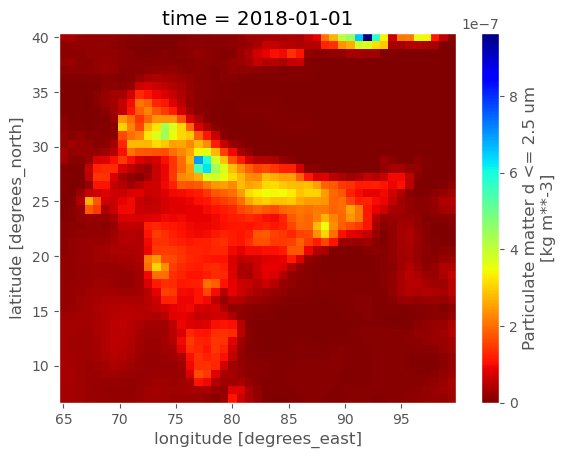

In [18]:
ds.pm2p5.isel(time=0).plot(cmap='jet_r')
plt.show()

# Masking Dataset Using India Boundary Shape File

In [19]:
# Shaping dataset
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [20]:
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_mask = add_shape_coord_from_data_array(ds, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_shape = ds_mask.drop_vars('MASK')

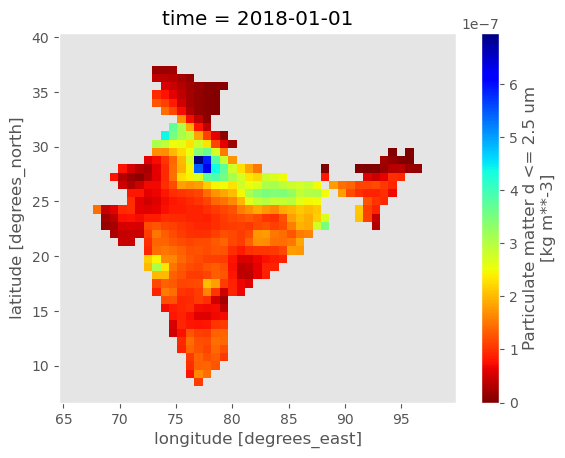

In [22]:
ds_shape.pm2p5.isel(time=0).plot(cmap='jet_r')
plt.show()

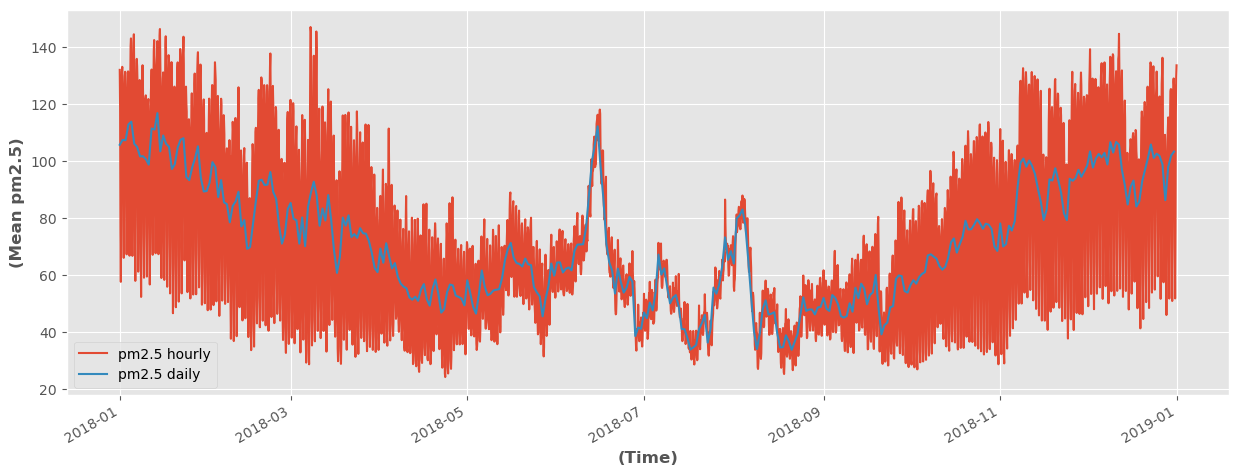

In [27]:
fig,axs = plt.subplots(1,1,figsize=(15,5))

data1_mean = ds_shape.pm2p5.mean(dim=('latitude', 'longitude'))*(10**(9))
data2_mean = ds_shape.pm2p5.resample(time='1D').mean().mean(dim=('latitude', 'longitude'))*(10**(9))

data1_mean.plot.line(ax=axs, label='pm2.5 hourly')
data2_mean.plot.line(ax=axs, label='pm2.5 daily')

axs.legend()
axs.set_xlabel('(Time)',weight='bold')
axs.set_ylabel('(Mean pm2.5)',weight='bold')
plt.show()

## Function for Loading Files and Adding Time Dimension 

In [2]:
#loading nc file and slice to get region covering india
def load_file(path,time):
    
    ds = xr.open_dataset(path)
    ds1 = ds.sel(lat=slice(7.0,39.0),lon=slice(67.0,99.0)) # Lat:(8,38), lon:(68,98)
    
    ds3 = add_time_dim(ds1,time)
    return ds3
    
    
    
#Adding Time Dimension and assigning coordinates
def add_time_dim(ds1,time_stamp):
    ds2 = ds1.expand_dims({'time':1}).assign_coords({'time':[time_stamp]})
    return ds2

## 2018 to 2019 Dataset List

In [3]:
#Loading dataset and date range

start_date = '2018-01' # starting year from which records are taken.

pm2p5_dir = glob.glob('Data/PM/*')
date_range = pd.date_range(start_date,periods=len(pm2p5_dir),freq='MS')

datasets = [ load_file(path,date_range[i]) for i,path in enumerate(pm2p5_dir)]

#ds.to_netcdf('./Data/PM_wtime'+f'/PM2p5_{i}.nc')
#ds = xr.concat(datasets,dim='time')

## Getting 2018 PM Data

In [5]:
#2018 DATA

ds4 = xr.concat(datasets[:12],dim='time')
ds4

<xarray.Dataset>
Dimensions:  (lon: 3200, lat: 3200, time: 12)
Coordinates:
  * lon      (lon) float64 67.0 67.01 67.03 67.04 ... 98.96 98.97 98.99 99.0
  * lat      (lat) float64 7.005 7.015 7.025 7.035 ... 38.97 38.97 38.99 38.99
  * time     (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    GWRPM25  (time, lat, lon) float32 nan nan nan nan ... 31.3 31.3 31.4 31.7
Attributes:
    Title:            Hybrid PM_2_._5 [\mug/m^3]
    Contact:          Aaron van Donkelaar <aaron.vandonkelaar@wustl.edu>
    References:       van Donkelaar et al., Monthly Global Estimates of Fine ...
    Filename:         C:\Users\Aaron\Documents\MATLAB\PM25_wMelanie\GlobalMon...
    Format:           NetCDF-4
    Delta_Lat:        0.010000228881835938
    Delta_Lon:        0.0099945068359375
    SpatialCoverage:  Asia
    Start_Date:       20180101
    End_Date:         20181231

## Ploting Graph for 2018/01

In [1]:
ds4.GWRPM25.isel(time=0).plot(cmap='jet_r')

NameError: name 'ds4' is not defined

## Regridding from 0.01 X 0.01(PM2.5)  to  0.25 X 0.25(BHL)

In [7]:
#output resolution
out_res = float(0.25)

#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98


ds5 = ds4.groupby_bins("lon", bins=new_lon).mean(dim="lon").groupby_bins("lat", bins=new_lat).mean(dim="lat")

#Renaming longitude and latitude coordinate
ds6 = ds5.rename({"lon_bins":"longitude","lat_bins":"latitude"})

ds6['latitude'] = new_lat[:-1] + interval_window
ds6['longitude'] = new_lon[:-1] + interval_window

ds6

<xarray.Dataset>
Dimensions:    (time: 12, longitude: 121, latitude: 121)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
  * longitude  (longitude) float64 68.0 68.25 68.5 68.75 ... 97.5 97.75 98.0
  * latitude   (latitude) float64 8.0 8.25 8.5 8.75 ... 37.25 37.5 37.75 38.0
Data variables:
    GWRPM25    (latitude, longitude, time) float32 nan nan nan ... 6.149 16.03
Attributes:
    Title:            Hybrid PM_2_._5 [\mug/m^3]
    Contact:          Aaron van Donkelaar <aaron.vandonkelaar@wustl.edu>
    References:       van Donkelaar et al., Monthly Global Estimates of Fine ...
    Filename:         C:\Users\Aaron\Documents\MATLAB\PM25_wMelanie\GlobalMon...
    Format:           NetCDF-4
    Delta_Lat:        0.010000228881835938
    Delta_Lon:        0.0099945068359375
    SpatialCoverage:  Asia
    Start_Date:       20180101
    End_Date:         20181231

## plotting graph 

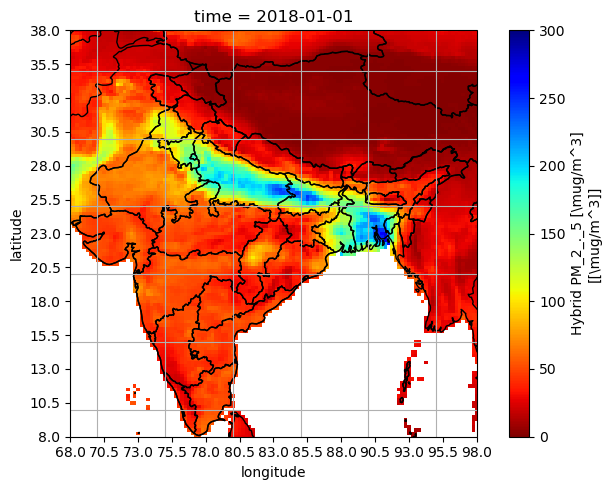

In [19]:
fig = plt.figure(figsize=(7,5))
cmap = plt.cm.get_cmap('jet')
projection=ccrs.PlateCarree(central_longitude=0)
ax=plt.axes(projection=projection)
#cmap = plt.cm.get_cmap('RdBu') ##Red/Blue 
#lat and long limits

ds6.GWRPM25.isel(time=0).plot(vmin=0, vmax=300,robust=True,cmap=cmap.reversed(),ax=ax)
ax.set_extent([68,98,8,38], crs=projection)
ax.coastlines() #adding coastline
ax.gridlines() #adding gridlines
ax.set_xticks(ds6.longitude[::10])
ax.set_yticks(ds6.latitude[::10])
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor='black') ##Adding borders
ax.add_feature(cartopy.feature.STATES, linestyle='-', edgecolor='black') ##adding state borders
plt.show()

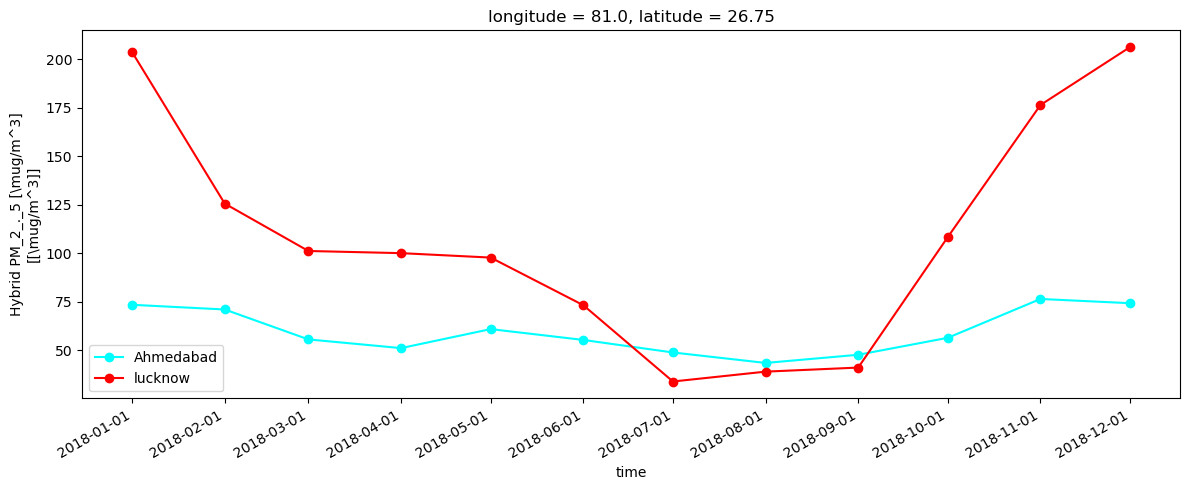

In [9]:
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
fig1 = ds6.GWRPM25.sel(latitude=23.0225,longitude=72.5714,method='nearest').plot(x='time',marker = 'o',color = 'cyan',label='Ahmedabad' )
fig2 = ds6.GWRPM25.sel(latitude=26.84,longitude=80.9462,method='nearest').plot(x='time',marker = 'o',color = 'red',label='lucknow')
plt.xticks(ds6.GWRPM25.time)
plt.legend()
plt.show()

In [10]:
#ds.to_netcdf('./Data/PM_wtime/3M_data.nc')
# ds1 = xr.open_dataset('./Data/PM_wtime/3M_data.nc')
# ds1



In [11]:
# #Adding Time Dimension

# time_1 = pd.DatetimeIndex(['2018-01-01 00:00:00'])
# time_2 = pd.DatetimeIndex(['2018-02-01 00:00:00'])
# time_3 = pd.DatetimeIndex(['2018-03-01 00:00:00'])

# ds1 = ds1.expand_dims({'time':1})
# ds1.dims

# ds2 = ds2.expand_dims({'time':1})
# ds2.dims

# ds3 = ds3.expand_dims({'time':1})
# ds3.dims

# ds1 = ds1.assign_coords({'time':time_1})
# ds2 = ds2.assign_coords({'time':time_2})
# ds3 = ds2.assign_coords({'time':time_3})


# ds3